## Importing Library

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.utils import np_utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## Reading Data

In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Data

In [4]:
X_train = train.drop("label",axis=True)
Y_train = train["label"]

In [5]:
X_train = X_train / 255.0
test = test / 255.0

In [6]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [7]:
#Encoding the output class label (One-Hot Encoding)
Y_train = to_categorical(Y_train, num_classes = 10)
Y_train[2]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

## EDA and Data Visualisation 

In [9]:
print("trainX shape:", X_train.shape, "\ntrainY shape:", Y_train.shape)

trainX shape: (37800, 28, 28, 1) 
trainY shape: (37800, 10)


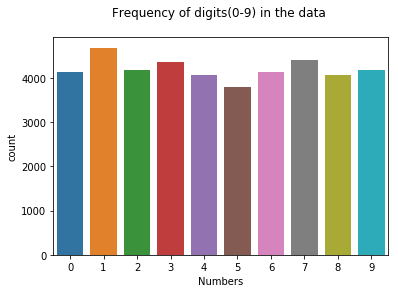

In [10]:
# train["label"].hist(bins=10)
classes = [0,1,2,3,4,5,6,7,8,9]
ax=sns.countplot(x="label", data=train)
ax.set_xticklabels(classes)
plt.xlabel("Numbers")
plt.title("Frequency of digits(0-9) in the data \n")
plt.show()

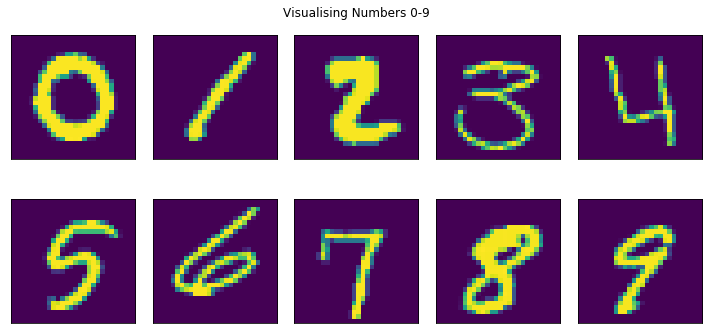

In [11]:
plt.figure(figsize=(10,5))
for i in range(10):
    
    plt.subplot(2,5,i+1)
    plt.imshow(np.array(train.iloc[:,1:][train["label"]==i].iloc[0,:]).reshape(28,28))
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle("Visualising Numbers 0-9")    
plt.tight_layout()
plt.show()

## Data Augmentation

* In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. This will help us in increasing the number of data in our dataset. 
* This will change the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(X_train)

For the data augmentation, I choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

## Model Building

In [13]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [15]:
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

## Callback

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=86),
                              epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 86
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 18s - loss: 0.4244 - accuracy: 0.8622 - val_loss: 0.0559 - val_accuracy: 0.9836
Epoch 2/30


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 14s - loss: 0.1276 - accuracy: 0.9617 - val_loss: 0.0408 - val_accuracy: 0.9888
Epoch 3/30
 - 13s - loss: 0.0955 - accuracy: 0.9715 - val_loss: 0.0389 - val_accuracy: 0.9888
Epoch 4/30
 - 13s - loss: 0.0789 - accuracy: 0.9769 - val_loss: 0.0337 - val_accuracy: 0.9900
Epoch 5/30
 - 14s - loss: 0.0719 - accuracy: 0.9795 - val_loss: 0.0292 - val_accuracy: 0.9910
Epoch 6/30
 - 13s - loss: 0.0645 - accuracy: 0.9807 - val_loss: 0.0290 - val_accuracy: 0.9917
Epoch 7/30
 - 13s - loss: 0.0649 - accuracy: 0.9815 - val_loss: 0.0278 - val_accuracy: 0.9929
Epoch 8/30
 - 13s - loss: 0.0618 - accuracy: 0.9815 - val_loss: 0.0212 - val_accuracy: 0.9940
Epoch 9/30
 - 14s - loss: 0.0601 - accuracy: 0.9827 - val_loss: 0.0352 - val_accuracy: 0.9902
Epoch 10/30
 - 13s - loss: 0.0609 - accuracy: 0.9830 - val_loss: 0.0238 - val_accuracy: 0.9936
Epoch 11/30
 - 14s - loss: 0.0597 - accuracy: 0.9831 - val_loss: 0.0267 - val_accuracy: 0.9929
Epoch 12/30
 - 13s - loss: 0.0643 - accuracy: 0.9822 - val_loss: 0.02

## Predictions

In [18]:
predictions = model.predict(test, verbose=0)
predictions[0:5]

array([[5.1700545e-15, 5.8743253e-12, 9.9999988e-01, 1.0105554e-07,
        3.3259808e-12, 9.7421610e-14, 1.2513506e-16, 3.0879274e-08,
        1.2150870e-09, 4.7752739e-12],
       [9.9999845e-01, 1.1967708e-11, 4.8921660e-08, 4.6559326e-10,
        4.3606430e-09, 1.9972299e-08, 9.8829737e-08, 3.2807050e-09,
        1.7055123e-07, 1.2504354e-06],
       [2.9503241e-26, 1.3372969e-28, 5.6015036e-20, 3.1391247e-22,
        4.5554862e-12, 5.9374077e-23, 8.6424391e-30, 3.4986173e-17,
        3.5358686e-14, 1.0000000e+00],
       [9.9934536e-01, 8.4044126e-11, 2.1787816e-06, 1.5767432e-08,
        4.6625783e-07, 9.9796614e-07, 4.4869954e-05, 1.3102381e-07,
        1.3393807e-05, 5.9264805e-04],
       [4.7198955e-18, 3.4382338e-16, 7.3792791e-08, 9.9999988e-01,
        8.0598676e-18, 1.7898441e-11, 3.4084206e-16, 2.1117011e-11,
        5.6502213e-08, 6.4421016e-13]], dtype=float32)

In [19]:
pred=[]
for i in list(range(0,len(predictions))):
    pred.append(np.argmax(predictions[i]))

In [20]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": pred})
submissions.to_csv("DR.csv", index=False, header=True)

## Post Training Visualisation

<Figure size 720x720 with 0 Axes>

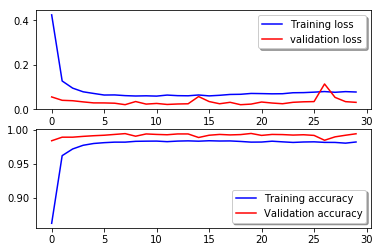

In [21]:
# Plot the loss and accuracy curves for training and validation 
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)